In [1]:
import os
import pandas as pd
import tiktoken
import openai

In [2]:
# Read API Key
with open('API_KEY.txt') as f:
    api_key = f.readlines()[0]

# Set API Key
openai.api_key = api_key

## Fine-Tuning & Chat Bots

Fine tuning model on custom dataset to make a Chat Bot.

We'll finetune a OpenAI model to answer Python related questions using StackOverflow Questions and Answers. Dataset comes from here: https://www.kaggle.com/datasets/stackoverflow/stacksample

In [3]:
# Load Dataset
qa_df = pd.read_csv("./data/python_qa.csv")
qa_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,ParentId,Answer
0,11060,912.0,2008-08-14T13:59:21Z,NaN,18,How should I unit test a code-generator?,This is a difficult and open-ended question I ...,11060,I started writing up a summary of my experienc...
1,17250,394.0,2008-08-20T00:16:40Z,NaN,24,Create an encrypted ZIP file in Python,I'm creating an ZIP file with ZipFile in Pytho...,17250,I created a simple library to create a passwor...
2,31340,242853.0,2008-08-27T23:44:47Z,NaN,71,"How do threads work in Python, and what are co...",I've been trying to wrap my head around how th...,31340,"Yes, because of the Global Interpreter Lock (G..."
3,34020,3561.0,2008-08-29T05:43:16Z,NaN,17,Are Python threads buggy?,A reliable coder friend told me that Python's ...,34020,Python threads are good for concurrent I/O pro...
4,34570,577.0,2008-08-29T16:10:41Z,2011-11-08T16:11:43Z,13,What is the best quick-read Python book out th...,I am taking a class that requires Python. We w...,34570,"I loved Dive Into Python, especially if you're..."


In [4]:
questions, answers = qa_df['Body'], qa_df['Answer']

In [5]:
questions

0       This is a difficult and open-ended question I ...
1       I'm creating an ZIP file with ZipFile in Pytho...
2       I've been trying to wrap my head around how th...
3       A reliable coder friend told me that Python's ...
4       I am taking a class that requires Python. We w...
                              ...                        
4424    I am trying to determine what percentage of th...
4425    How can we make a class represent itself as a ...
4426    I thought I could make my python (2.7.10) code...
4427    Say, I have given a DataFrame with most of the...
4428    Let's say I have the following code:\n\na = [1...
Name: Body, Length: 4429, dtype: object

In [6]:
answers

0       I started writing up a summary of my experienc...
1       I created a simple library to create a passwor...
2       Yes, because of the Global Interpreter Lock (G...
3       Python threads are good for concurrent I/O pro...
4       I loved Dive Into Python, especially if you're...
                              ...                        
4424    setup\ncreate 2 time series\n\nfrom StringIO i...
4425    TLDR: It's impossible to make custom classes r...
4426    You are not indexing. You are yielding a list;...
4427    You can create a look up data frame from the d...
4428    Use itertools.product within a list comprehens...
Name: Answer, Length: 4429, dtype: object

## Format Data into JSON Format for OpenAI Model Finetuning

In [7]:
qa_openai_format = [{"prompt": q, "completion": a} for q,a in zip(questions, answers)]

In [8]:
qa_openai_format[4]

{'prompt': 'I am taking a class that requires Python. We will review the language in class next week, and I am a quick study on new languages, but I was wondering if there are any really great Python books I can grab while I am struggling through the basics of setting up my IDE, server environment and all those other "gotchas" that come with a new programming language. Suggestions?\n',
 'completion': "I loved Dive Into Python, especially if you're a quick study.  The beginning basics are all covered (and may move slowly for you), but the latter few chapters are great learning tools.\n\nPlus, Pilgrim is a pretty good writer.\n"}

In [9]:
# Base Model
response = openai.Completion.create(
    model='text-babbage-001',
    prompt=qa_openai_format[4]['prompt'],
    max_tokens=256,
    temperature=0.1,
)

In [10]:
# Model Hallucination
print(response['choices'][0]['text'])


There are a few great Python books that you could consider while you are learning Python. The first book that comes to mind is "Python for Data Science" by Geoffrey Hinton. This book is a great introduction to Python and provides a lot of helpful examples and code examples. Additionally, the "Python for Data Science" book is available as an e-book. The second book that you could consider is "Python for Data Science and Machine Learning" by Geoffrey Hinton. This book is a great introduction to Python and machine learning and provides a lot of helpful examples and code examples. Additionally, the "Python for Data Science and Machine Learning" book is available as an e-book.


## Get Model FineTuning Cost Estimates

In [11]:
def num_tokens_from_string(string, encoding_name):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [12]:
# Num rows to use for finetuning - to reduce cost
dataste_size = 500

In [13]:
import json

with open("data/example_training_data_filtered.json", "w") as f:
    for entry in qa_openai_format[:dataste_size]:
        f.write(json.dumps(entry))
        f.write('\n')

In [14]:
token_counter = 0

for element in qa_openai_format[:500]:
    for prompt, completion in element.items():
        token_counter += num_tokens_from_string(prompt, 'gpt2')
        token_counter += num_tokens_from_string(completion, 'gpt2')

In [15]:
token_counter

197362

In [16]:
# Cost Estimate for finetuning Babbage model on this dataset

# Cost per 1000 tokens
cost_per_thousand_tokens = 0.0006

# Number of default Epochs
num_epochs = 4

estimated_cost = cost_per_thousand_tokens * num_epochs * token_counter/1000

print("Cost Estimate: ${:2f}".format(estimated_cost))

Cost Estimate: $0.473669


## Model FineTuning

Ref.: https://platform.openai.com/docs/guides/fine-tuning

In [22]:
# !openai api fine_tunes.create -t "/Users/anujdutt/Downloads/Learning/OpenAI_Demo/data/example_training_data_filtered.json" -m babbage

Error: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://onboard.openai.com for details, or email support@openai.com if you have any questions.


### Model Training Job Creation

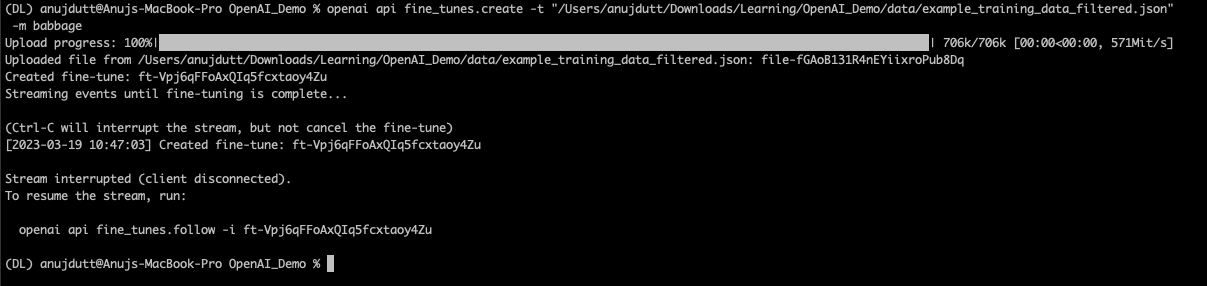

## Model Training Followup

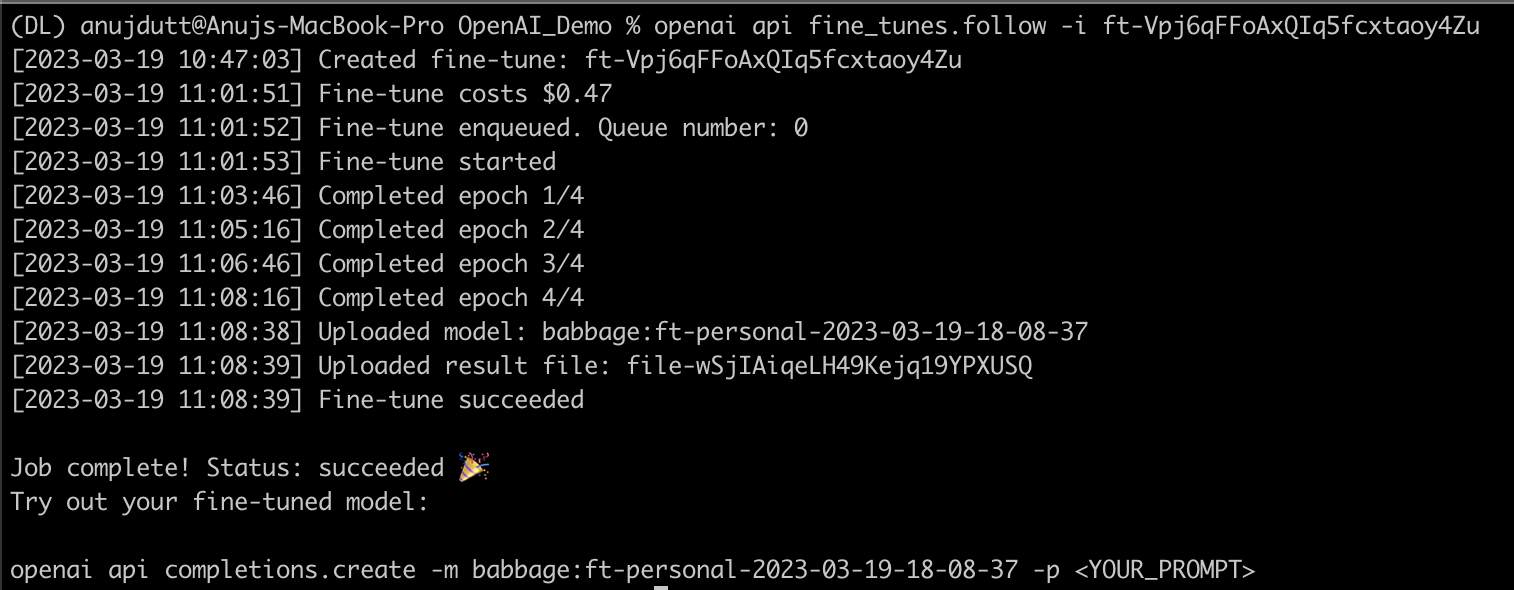


## Base Model vs FineTuned Model

In [23]:
# Base Model
response = openai.Completion.create(
    model='text-babbage-001',
    prompt="What are some good Python books?",
    max_tokens=256,
)

In [24]:
# Model Hallucination
print(response['choices'][0]['text'])



Some good Python books include How to Play Python, reading Python for Dummies, Python for Applications, and Python for Data Science.


In [25]:
# Finetuned Model Name
fine_tuned_model = "babbage:ft-personal-2023-03-19-18-08-37"

In [26]:
response = openai.Completion.create(
    model=fine_tuned_model,
    prompt="What are some good Python books?",
    max_tokens=256,
)

In [27]:
# Model Hallucination
print(response['choices'][0]['text'])


You Got This? is a great source.

If you need more than just an overview: dummies have some good stuff on this topic (e.g. Python Game Development, Core Python).

Also, A quick Python reference, though a little out of date.

and PyGetDB sql manger is good for MySQL. You may want to search for Python GDB in a local library catalog.

For the classics: the Big Bag of Books on Python.

And How to Program in Python.

Also check out these lists: Practical Python Booklist, Tutorials in Python, and PyBooklist to name a few.


***Finetuned model is much more conversational - as stackoverflow also has a lots of text - and gives better responses than the base model.***

## Pricing Comparison

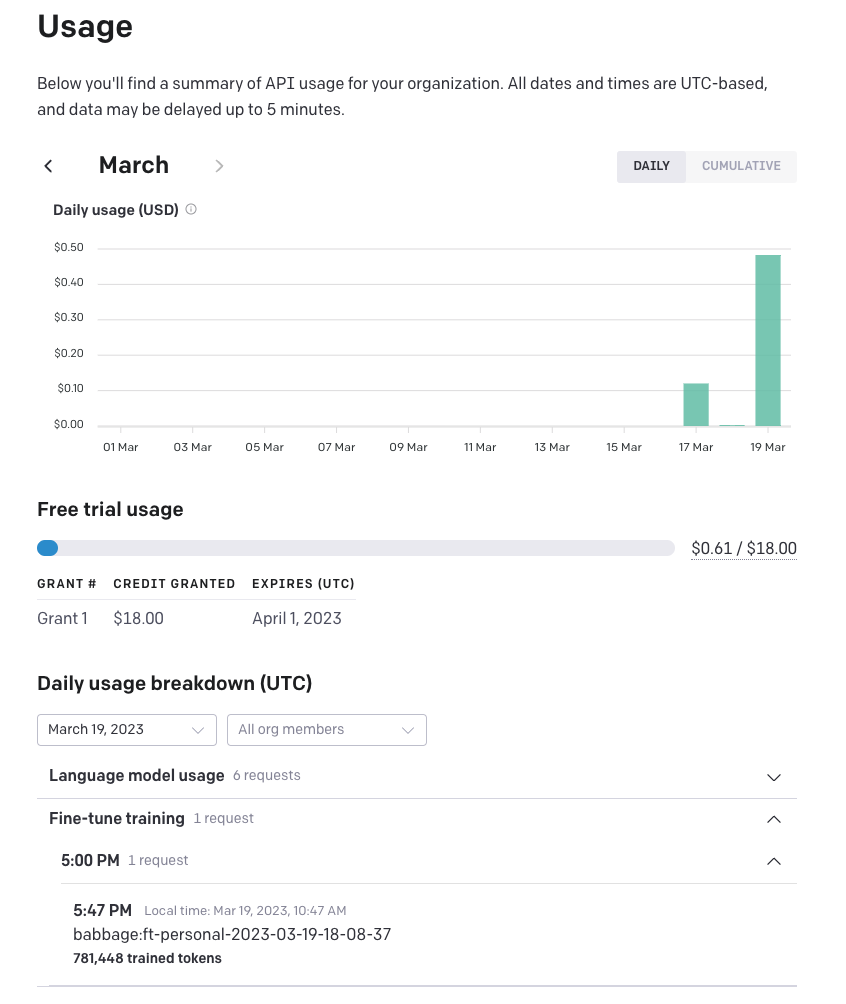